# Import the required libraries

In [46]:
import torch
torch.cuda.set_device(0)
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load a model
model = YOLO("./best.pt")  # load a base model (recommended for training)

In [3]:
model.info()

Model summary: 365 layers, 43630611 parameters, 0 gradients, 165.4 GFLOPs


(365, 43630611, 0, 165.4030848)

# Alright now let's load an image and display it

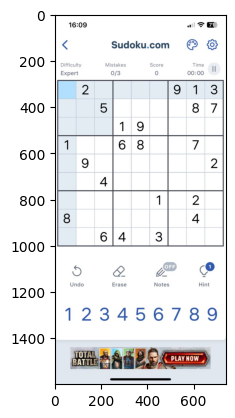

In [26]:
image_path = "./phone.jpeg"
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# Now let's detect the grid

In [27]:
results = model.predict(img)


0: 416x192 1 sudoku, 142.0ms
Speed: 3.0ms preprocess, 142.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 192)


# Now let's process the prediction to get the bounding box

[   0  275  739 1014]
0.9631003737449646


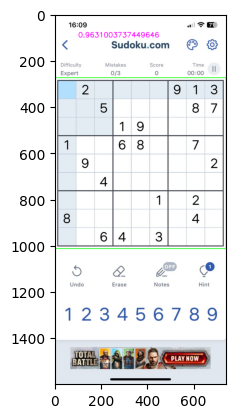

In [28]:
for result in results:                                         # iterate results
    boxes = result.boxes.cpu().numpy()                         # get boxes on cpu in numpy
    for box in boxes:                                          # iterate boxes
        r = box.xyxy[0].astype(int)                            # get corner points as int
        print(r)
        class_id = box.cls[0].astype(int)                       # get predicted class as int
        confidences = box.conf[0].astype(float)                 # get confidences as float
        print(confidences)
        cv2.rectangle(img_rgb, r[:2], r[2:], (0, 255, 0), 2)   # draw boxes on img
        cv2.putText(img_rgb,f"{confidences}",(100,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2)
cv2.imwrite("result.jpg",img_rgb)
plt.imshow(img_rgb)

# Now let's get our ROI

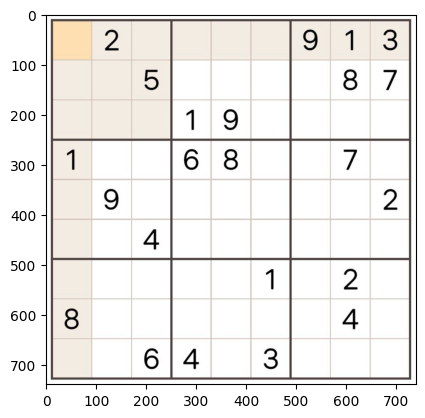

In [33]:
cropped = img[r[1]:r[3],r[0]:r[2]]
plt.imshow(cropped)

# Time for some image processing

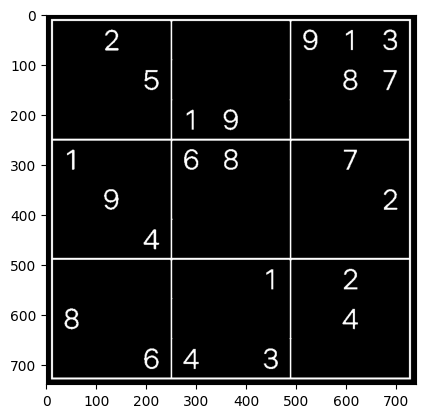

In [43]:
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
# basic thresolding
mask = cv2.inRange(gray, 0, 100)

plt.imshow(mask,cmap="gray")

# Let's slice it to cells

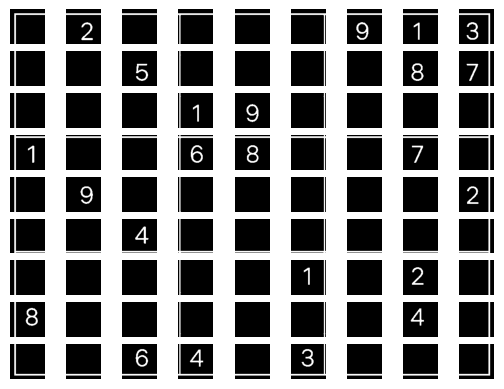

In [59]:
height, width = mask.shape
cell_h, cell_w = height//9, width//9
for i in range(9):
    for j in range(9):
        cell = mask[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cell, cmap="gray")
        plt.axis("off")

# Let's try to remove the borders

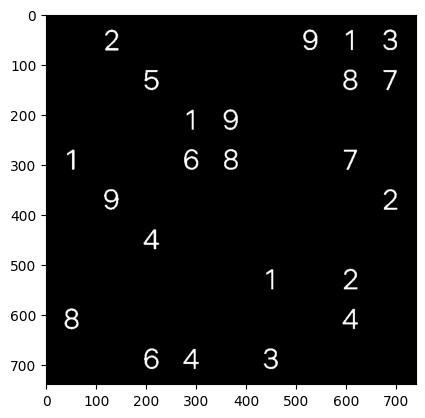

In [47]:
width, height = mask.shape
cell_size = min(width, height) // 9
blurred_mask = cv2.GaussianBlur(mask, (5, 5), 0)
mask_edges = cv2.Canny(blurred_mask, 1, 255, apertureSize=3)
lines = cv2.HoughLines(mask_edges, 1, np.pi / 180, 130)
filtering_mask = np.zeros_like(mask)

for rho, theta in lines[:, 0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho

    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))

    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(filtering_mask, (x1, y1), (x2, y2), (255, 255, 255), 2)
kernel = np.ones((5, 5), np.uint8)
filtering_mask = cv2.dilate(filtering_mask, kernel, iterations=2)
final_mask = cv2.subtract(mask, filtering_mask)

plt.imshow(final_mask,cmap="gray")

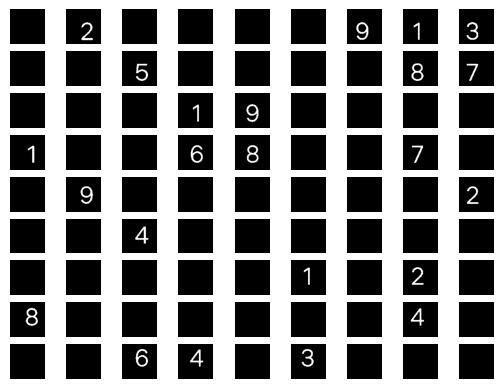

In [52]:
# slice the mask to 81 cell equally
cells = [[None for _ in range(9)] for _ in range(9)]
cell_h, cell_w = height//9, width//9
for i in range(9):
    for j in range(9):
        cell = final_mask[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
        cells[i][j] = cell
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cell, cmap="gray")
        plt.axis("off")

# Ocr each cell

In [55]:
import easyocr
reader = easyocr.Reader(['en'], gpu=True)

def simple_ocr(image):
    blurred_image = cv2.blur(image, (5, 5))
    result = reader.readtext(blurred_image, paragraph=True, allowlist="123456789")
    try:
        return int(result[0][1]) if len(result[0]) > 0 else 0
    except:
        return 0

grid = np.zeros((9, 9), dtype=np.int32)
# iterate the cells matrix
for i in range(9):
    for j in range(9):
        cell = cells[i][j]
        # if the cell is not empty
        if np.sum(cell) > 0:
            # get the digit inside the cell
            digit = simple_ocr(cell)
            # put the digit in the grid
            grid[i][j] = digit
        
        
for i in range(9):
    for j in range(9):
        print(grid[i][j], end=" ")
    print()


0 2 0 0 0 0 9 1 3 
0 0 5 0 0 0 0 8 7 
0 0 0 1 9 0 0 0 0 
1 0 0 6 8 0 0 7 0 
0 9 0 0 0 0 0 0 2 
0 0 4 0 0 0 0 0 0 
0 0 0 0 0 1 0 2 0 
8 0 0 0 0 0 0 4 0 
0 0 6 4 0 3 0 0 0 


# Solve the sudoku and display the solution

In [56]:
from ortools.sat.python import cp_model

def solve_sudoku(input_grid):
    """Solves the sudoku problem with the CP-SAT solver."""
    # Create the model.
    model = cp_model.CpModel()

    cell_size = 3
    line_size = cell_size**2
    line = list(range(0, line_size))
    cell = list(range(0, cell_size))

    initial_grid = input_grid

    grid = {}
    for i in line:
        for j in line:
            grid[(i, j)] = model.NewIntVar(1, line_size, "grid %i %i" % (i, j))

    # AllDifferent on rows.
    for i in line:
        model.AddAllDifferent(grid[(i, j)] for j in line)

    # AllDifferent on columns.
    for j in line:
        model.AddAllDifferent(grid[(i, j)] for i in line)

    # AllDifferent on cells.
    for i in cell:
        for j in cell:
            one_cell = []
            for di in cell:
                for dj in cell:
                    one_cell.append(grid[(i * cell_size + di, j * cell_size + dj)])

            model.AddAllDifferent(one_cell)

    # Initial values.
    for i in line:
        for j in line:
            if initial_grid[i][j]:
                model.Add(grid[(i, j)] == initial_grid[i][j])

    # Solve and print out the solution.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    if status == cp_model.OPTIMAL:
        for i in line:
            print([int(solver.Value(grid[(i, j)])) for j in line])
        return [int(solver.Value(grid[(i, j)])) for i in line for j in line]


In [57]:
solve_sudoku(grid)

[4, 2, 7, 5, 6, 8, 9, 1, 3]
[9, 1, 5, 3, 4, 2, 6, 8, 7]
[6, 8, 3, 1, 9, 7, 2, 5, 4]
[1, 3, 2, 6, 8, 5, 4, 7, 9]
[5, 9, 8, 7, 3, 4, 1, 6, 2]
[7, 6, 4, 2, 1, 9, 5, 3, 8]
[3, 4, 9, 8, 5, 1, 7, 2, 6]
[8, 7, 1, 9, 2, 6, 3, 4, 5]
[2, 5, 6, 4, 7, 3, 8, 9, 1]


[4,
 2,
 7,
 5,
 6,
 8,
 9,
 1,
 3,
 9,
 1,
 5,
 3,
 4,
 2,
 6,
 8,
 7,
 6,
 8,
 3,
 1,
 9,
 7,
 2,
 5,
 4,
 1,
 3,
 2,
 6,
 8,
 5,
 4,
 7,
 9,
 5,
 9,
 8,
 7,
 3,
 4,
 1,
 6,
 2,
 7,
 6,
 4,
 2,
 1,
 9,
 5,
 3,
 8,
 3,
 4,
 9,
 8,
 5,
 1,
 7,
 2,
 6,
 8,
 7,
 1,
 9,
 2,
 6,
 3,
 4,
 5,
 2,
 5,
 6,
 4,
 7,
 3,
 8,
 9,
 1]